In [ ]:
!nvidia-smi

Sun Jul 23 15:15:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |  14543MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install unet
!pip install utils

In [10]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [11]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob

image_filenames_train = []

# Relative path example
mask_files = glob.glob('/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# # Absolute path example
# mask_files = glob.glob('C:\\Users\\SHAIK AMEER BASHA\\archive (9)\\lgg-mri-segmentation\\kaggle_3m\\*\\*_mask*')

# in Kaggle
# mask_files = glob.glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for file_path in mask_files:
    image_filenames_train.append(file_path.replace('_mask', ''))

print(image_filenames_train[:10])
print(len(image_filenames_train))


['/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_23.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_26.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_9.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_16.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_22.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_19.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12.tif', '/content/drive/MyDrive/archive (9)/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15.tif', '/content/drive/MyDrive/archive (9)/lgg-

In [12]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K

plt.style.use("ggplot")


def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    """ This function plots a grid of images and their corresponding masks from given lists of image and mask paths.
    It uses matplotlib for plotting and OpenCV for reading and processing the images.

    Parameters:
    -----------
    rows : int
        The number of rows in the plot grid.

    columns : int
        The number of columns in the plot grid.

    list_img_path : list of str
        A list of paths to the image files to be plotted.

    list_mask_path : list of str
        A list of paths to the mask files to be plotted.

    Returns:
    --------
    None

    Notes:
    ------
    The images are displayed in RGB format, and the masks are overlaid on the images
    with a transparency of 0.4. """
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()


def dice_coefficients(y_true, y_pred, smooth=100):
    """
    Computes the Dice similarity coefficient between the true and predicted values.

    The Dice coefficient is a statistical metric used to gauge the similarity of two samples.
    With a range from 0 to 1, the Dice coefficient is 1 when the two samples are identical and
    0 when they share no elements. A smoothing term is included to prevent division by zero.

    This function is typically used as a loss function for binary segmentation tasks,
    where the true and predicted values are binary masks of the same size.

    Parameters:
    -----------
    y_true : tensor
        The ground truth values. Typically a binary mask.

    y_pred : tensor
        The predicted values. Typically a binary mask.

    smooth : float, optional
        A smoothing factor to prevent division by zero. Default is 100.

    Returns:
    --------
    float
        The Dice similarity coefficient between the true and predicted values.

    Note:
    -----
    The inputs are flattened to 1D tensors before computation to handle
    both single and multi-channel inputs.
    """

    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):
    """
    The Dice loss function for image segmentation models.

    The Dice loss is a measure of the overlap between the prediction (y_pred)
    and the ground truth (y_true). It ranges from 0 to 1, where a Dice loss
    of 1 indicates perfect overlap (i.e., a perfect segmentation), while a Dice
    loss of 0 indicates no overlap.

    The 'smooth' parameter is a small constant added to the numerator and
    denominator of the Dice coefficient to avoid division by zero errors
    and to stabilize the training.

    Parameters:
    y_true (tf.Tensor): Ground truth. Tensor of the same shape as y_pred.
    y_pred (tf.Tensor): Model prediction. Tensor output from the model.
    smooth (float, optional): A smoothing constant to avoid division by zero errors. Default is 100.

    Returns:
    float: The computed Dice loss.

    Why the negative sign here i.e. -dice_coefficients

    most optimization algorithms are designed to minimize a function rather than maximize it. Therefore, to convert the maximization problem to a minimization problem, we take the negative of the Dice coefficient. As a result, when the Dice coefficient is high (which is good), the loss is low, and when the Dice coefficient is low (which is bad), the loss is high. This allows the model to use standard optimization techniques to find the best parameters.

    """

    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    """
    Calculates the Intersection over Union (IoU) between the true and predicted values.

    IoU, also known as the Jaccard Index, is a metric used to quantify the percent overlap
    between the target mask and our prediction output. It's often used in segmentation problems
    to evaluate the quality of predictions.

    This function is generally used for evaluating segmentation tasks where the true and
    predicted outputs are binary masks of the same size.

    Parameters:
    -----------
    y_true : tensor
        The ground truth values. Typically a binary mask.

    y_pred : tensor
        The predicted values. Typically a binary mask.

    smooth : float, optional
        A smoothing factor to prevent division by zero. Default is 100.

    Returns:
    --------
    float
        The Intersection over Union (IoU) between the true and predicted values.

    Note:
    -----
    The inputs are not flattened to 1D tensors before computation because Keras backend
    operations automatically broadcast the tensors to the appropriate shapes.
    """
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou



def jaccard_distance(y_true, y_pred):
    """
    Function to compute the Jaccard distance between the true labels and the predicted labels.

    The Jaccard distance, which is a measure of dissimilarity between sets, is computed as one minus
    the intersection over union (IoU) of the sets. A lower Jaccard distance between the predicted labels
    and the true labels indicates a better model fit.

    Parameters:
    y_true (np.array): The ground truth label array (binary mask).
    y_pred (np.array): The predicted label array (binary mask).

    Returns:
    float: The Jaccard distance between the ground truth labels and the predicted labels.
    """

    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)


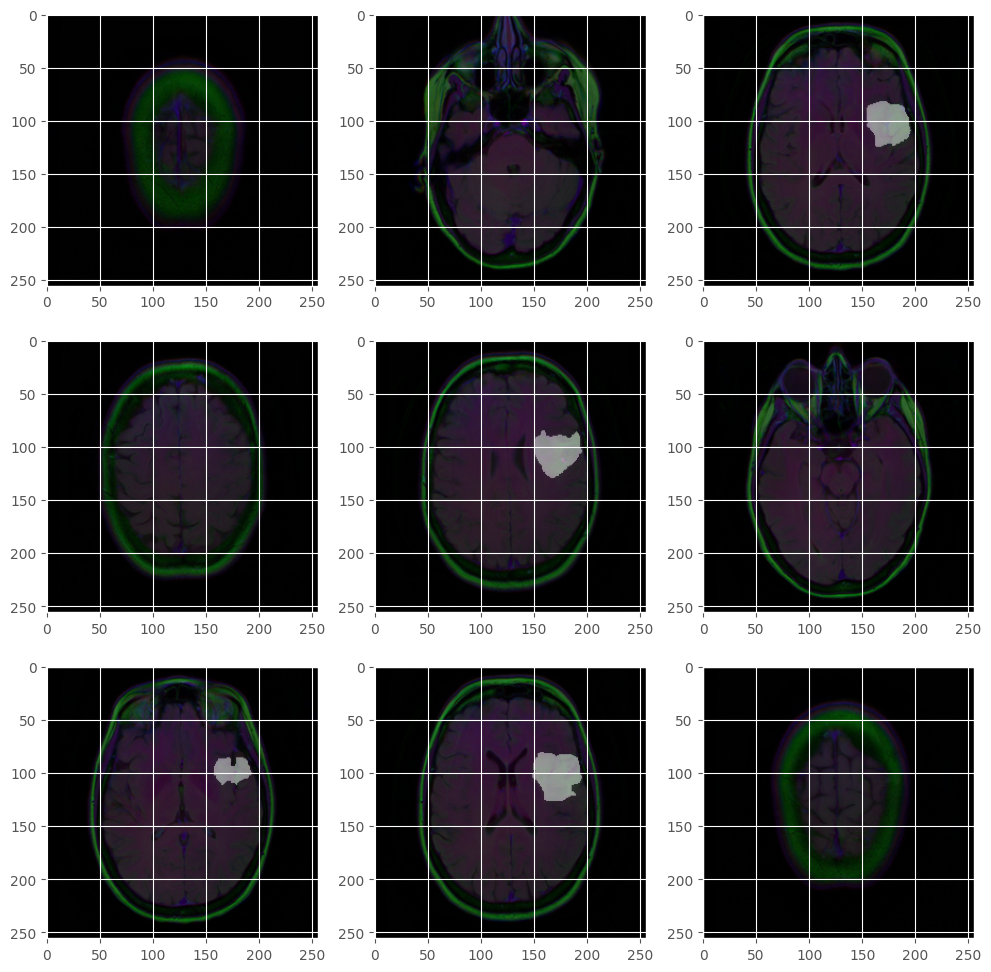

In [ ]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [13]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [14]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras import backend as K


def unet(input_size=(256, 256, 3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [16]:
EPOCHS = 10
BATCH_SIZE = 16
learning_rate = 1e-4
smooth=100

In [ ]:
df_train.isnull().sum()

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

train_generator_param = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_param, target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/archive (9)/1unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: -0.1418 - binary_accuracy: 0.9298 - iou: 0.0786 - dice_coefficients: 0.1418 Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01932, saving model to /content/drive/MyDrive/archive (9)/1unet.hdf5
176/176 [==============================] - 2344s 13s/step - loss: -0.1418 - binary_accuracy: 0.9298 - iou: 0.0786 - dice_coefficients: 0.1418 - val_loss: -0.0193 - val_binary_accuracy: 0.9899 - val_iou: 0.0100 - val_dice_coefficients: 0.0193
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: -0.2485 - binary_accuracy: 0.9873 - iou: 0.1462 - dice_coefficients: 0.2483
Epoch 2: val_loss improved from -0.01932 to -0.11043, saving model to /content/drive/MyDrive/archive (9)/1unet.hdf5
176/176 [==============================] - 184s 939ms/step - loss: -0.2485 - binary_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

train_generator_param = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_gen = train_generator(df_train, BATCH_SIZE, train_generator_param, target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])


In [ ]:
from tensorflow.keras.models import load_model

# Load the previously trained model
model = load_model('/content/drive/MyDrive/archive (9)/1unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients})
decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/archive (9)/1unet.hdf5', verbose=1, save_best_only=True)]
# Define the number of additional epochs you want to train
additional_epochs = 10

# Continue training the model
history1 = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    initial_epoch=EPOCHS,  # Set the initial epoch to the previously completed epochs
    epochs=EPOCHS + additional_epochs,  # Set the total number of epochs to the sum of completed and additional epochs
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)
